## Setup


In [1]:
!pip install transformers datasets accelerate xformers wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import wandb
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict, load_from_disk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

In [3]:
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})

In [4]:
seed = 42
data_path = "./data/irony_clean_data"
model_ckpt = "UBC-NLP/MARBERT"
# model_ckpt = "aubmindlab/bert-base-arabertv2"
model_name = "marbert-finetuned-wanlp_sarcasm"
model_path = f"./models/{model_name}"

## Data Preprocessing


In [5]:
dataset = load_from_disk(data_path)
dataset

Dataset({
    features: ['labels', 'text'],
    num_rows: 12037
})

In [6]:
train_data, valid_data = train_test_split(
    dataset.to_pandas(),
    random_state=seed,
    train_size=0.6,
    stratify=dataset[:]["labels"],
)

valid_data, test_data = train_test_split(
    valid_data,
    random_state=seed,
    train_size=0.5,
    stratify=valid_data["labels"],
)

In [7]:
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [8]:
train_data.labels.value_counts(normalize=True)

0    0.884243
1    0.115757
Name: labels, dtype: float64

In [9]:
valid_data.labels.value_counts(normalize=True)

0    0.884088
1    0.115912
Name: labels, dtype: float64

In [10]:
valid_data.labels.value_counts(normalize=True)

0    0.884088
1    0.115912
Name: labels, dtype: float64

In [11]:
dataset = DatasetDict({})
dataset["train"] = Dataset.from_pandas(train_data)
dataset["valid"] = Dataset.from_pandas(valid_data)
dataset["test"] = Dataset.from_pandas(test_data)
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 7222
    })
    valid: Dataset({
        features: ['labels', 'text'],
        num_rows: 2407
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 2408
    })
})

In [12]:
label_names = ["Non-Sarcasm", "Sarcasm"]

In [13]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

## Tokenization


In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
def tokenize_ds(batch):
    return tokenizer(batch["text"], truncation=True)

In [16]:
encoded_data = dataset.map(tokenize_ds, batched=True, remove_columns=["text"])

Map:   0%|          | 0/7222 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2407 [00:00<?, ? examples/s]

Map:   0%|          | 0/2408 [00:00<?, ? examples/s]

In [17]:
encoded_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7222
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2407
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2408
    })
})

## Modeling


In [18]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average="binary")
    prec = precision_score(labels, pred, average="binary")
    rec = recall_score(labels, pred, average="binary")
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Training


In [21]:
with open("./data/access_tokens.json") as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
wandb.init(project="irony-detection", name="stratified-weighted")

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


In [23]:
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    logging_steps=50,
    learning_rate=2e-5,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
)

In [24]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [25]:
w = dataset["train"].to_pandas().labels.value_counts(normalize=True).to_numpy()
w = 1 / w
w = w / w.sum()
w = torch.tensor(w, dtype=torch.float32).to(device=device)
w

tensor([0.1158, 0.8842], device='cuda:0')

In [26]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")  # [batch_size, num_labels]
        # del inputs['labels']
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = torch.nn.CrossEntropyLoss(weight=w)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [27]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.290400,0.494696,0.940174,0.819905,0.620072,0.706122
2,0.219900,0.406009,0.940590,0.734483,0.763441,0.748682
3,0.054500,0.636173,0.948484,0.775801,0.781362,0.778571


TrainOutput(global_step=678, training_loss=0.22140679844712788, metrics={'train_runtime': 274.0406, 'train_samples_per_second': 79.061, 'train_steps_per_second': 2.474, 'total_flos': 553274243876760.0, 'train_loss': 0.22140679844712788, 'epoch': 3.0})

In [29]:
trainer.evaluate(encoded_data["test"], metric_key_prefix="test")

{'test_loss': 0.3519429564476013,
 'test_Accuracy': 0.9514119601328903,
 'test_Precision': 0.81640625,
 'test_Recall': 0.7491039426523297,
 'test_F1': 0.7813084112149532,
 'test_runtime': 6.6572,
 'test_samples_per_second': 361.716,
 'test_steps_per_second': 11.416,
 'epoch': 3.0}

In [30]:
outs = trainer.predict(encoded_data["test"])
preds = np.argmax(outs[0], axis=-1)
labels = outs[1]

print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 Non-Sarcasm       0.97      0.98      0.97      2129
     Sarcasm       0.82      0.75      0.78       279

    accuracy                           0.95      2408
   macro avg       0.89      0.86      0.88      2408
weighted avg       0.95      0.95      0.95      2408



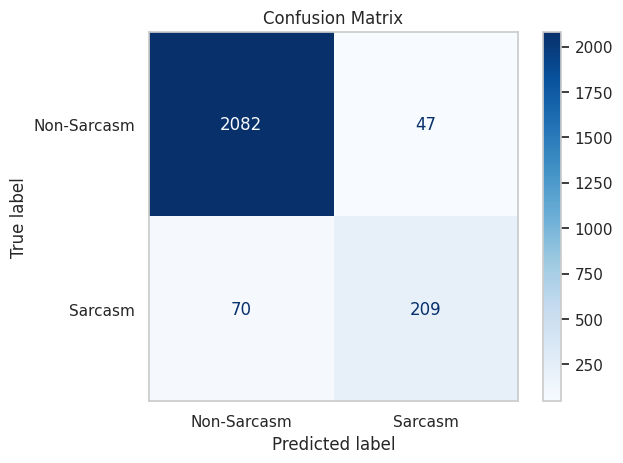

In [31]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("./data/cm.png", dpi=720)
plt.show()

In [32]:
from huggingface_hub import notebook_login

notebook_login()

In [33]:
trainer.push_to_hub(commit_message="trained model on the new 8-iterations clean data")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

'https://huggingface.co/Bmalmotairy/marbert-finetuned-wanlp_sarcasm/tree/main/'

In [34]:
wandb.finish()

eval/Accuracy,▁▁█
eval/F1,▁▅█
eval/Precision,█▁▄
eval/Recall,▁▇█
eval/loss,▄▁█
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
test/Accuracy,▁
test/F1,▁
test/Precision,▁
